Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
patool: Extracting /content/drive/MyDrive/Hood College/archive.zip ...
patool: running /usr/bin/7z x -o/content/extracted_images -- "/content/drive/MyDrive/Hood College/archive.zip"
patool: ... /content/drive/MyDrive/Hood College/archive.zip extracted to `/content/extracted_images'.
Found 14000 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.
Class Names: {'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9}
Epoch 1/10
438/438 [==============================] - 322s 730ms/step - loss: 1.2871 - accuracy: 0.6571 - val_loss: 18.5222 - val_accuracy: 0.1103
Epoch 2/10
438/438 [==============================] - 323s 737ms/step - loss: 0.1876 - accuracy: 0.9359 - val_loss: 1.0166 - val_accuracy: 0.7877
Epoch 3/10
438/438 [==============================] - 320s 730ms/step - loss: 0.1247 - accuracy: 0.9619

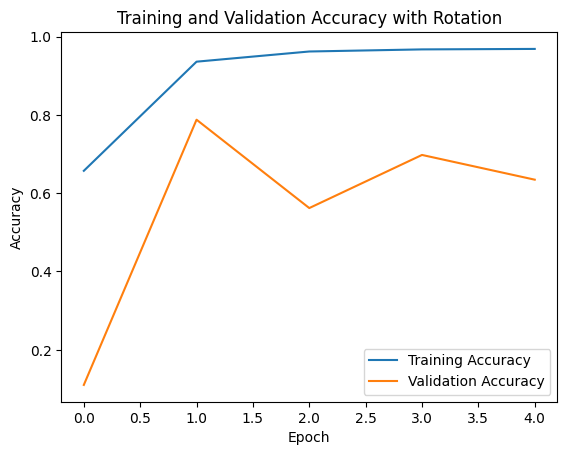

In [3]:
!pip install patool==1.12
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import patoolib

# Mount Google Drive
drive.mount('/content/drive')
patoolib.extract_archive("/content/drive/MyDrive/Hood College/archive.zip", outdir="/content/extracted_images")

# Define the directory containing the dataset
data_dir = '/content/extracted_images/leapGestRecog'

# Create an ImageDataGenerator with rotation augmentation
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.3,  # Reserve 30% of the dataset for validation
    rotation_range=30,     # Randomly rotate images by up to 30 degrees
    rescale=1.0/255.0,     # Scale pixel values to [0, 1]
    horizontal_flip=False  # Only rotation applied, no horizontal flip
)

# Load the training dataset with rotation applied
train_dataset_rotated = data_augmentation.flow_from_directory(
    directory=data_dir,           # Path to the main dataset directory
    target_size=(227, 227),        # Resize images to 227x227 pixels (AlexNet input size)
    batch_size=32,                 # Load images in batches of 32
    class_mode='categorical',      # Use categorical labels (one-hot encoded)
    subset='training',             # Use "training" for the training set
    seed=123                       # Seed for reproducibility
)

# Load the validation dataset without augmentation (using the same rescaling factor)
validation_dataset = data_augmentation.flow_from_directory(
    directory=data_dir,
    target_size=(227, 227),        # Resize images to 227x227 pixels (AlexNet input size)
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=123
)

# Display class names to verify labels
class_names = train_dataset_rotated.class_indices
print("Class Names:", class_names)

# Build the AlexNet model
def build_alexnet(input_shape=(227, 227, 3), num_classes=len(class_names)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
        tf.keras.layers.MaxPooling2D((3, 3), strides=2),

        tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
        tf.keras.layers.MaxPooling2D((3, 3), strides=2),

        tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
        tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
        tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
        tf.keras.layers.MaxPooling2D((3, 3), strides=2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Set the learning rate for the optimizer
learning_rate = 0.0001

# Compile the AlexNet model
alexnet_model = build_alexnet()
alexnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Implement Early Stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the augmented dataset (rotation applied)
history = alexnet_model.fit(
    train_dataset_rotated,
    validation_data=validation_dataset,
    epochs=10,  # Adjust the number of epochs as needed
    callbacks=[early_stopping],  # Include Early Stopping
    verbose=1
)

# Evaluate the model on the validation set
val_loss, val_acc = alexnet_model.evaluate(validation_dataset, verbose=2)
print(f"Validation accuracy after rotation: {val_acc:.4f}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy with Rotation')
plt.show()
